In [9]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout

In [13]:
women_tshirts = pd.read_csv('women_tshirts.csv')
women_tshirts.head()

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10
0,32601,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,NaN,NaN,NaN
1,32602,Women Tshirts,8,yellow,loose,long,default,default,long sleeves,regular sleeves,NaN,NaN,NaN
2,32603,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,NaN,NaN,NaN
3,32604,Women Tshirts,8,multicolor,loose,long,default,default,long sleeves,regular sleeves,NaN,NaN,NaN
4,32605,Women Tshirts,8,multicolor,loose,long,default,default,default,regular sleeves,NaN,NaN,NaN


In [14]:
women_tshirts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18774 entries, 0 to 18773
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        18774 non-null  int64  
 1   Category  18774 non-null  object 
 2   len       18774 non-null  int64  
 3   attr_1    17285 non-null  object 
 4   attr_2    14801 non-null  object 
 5   attr_3    16580 non-null  object 
 6   attr_4    16161 non-null  object 
 7   attr_5    17034 non-null  object 
 8   attr_6    16041 non-null  object 
 9   attr_7    15460 non-null  object 
 10  attr_8    510 non-null    object 
 11  attr_9    0 non-null      float64
 12  attr_10   0 non-null      float64
dtypes: float64(2), int64(2), object(9)
memory usage: 1.9+ MB


In [15]:
column_to_drop = ['len','attr_9','attr_10']
women_tshirts = women_tshirts.drop(column_to_drop, axis=1)

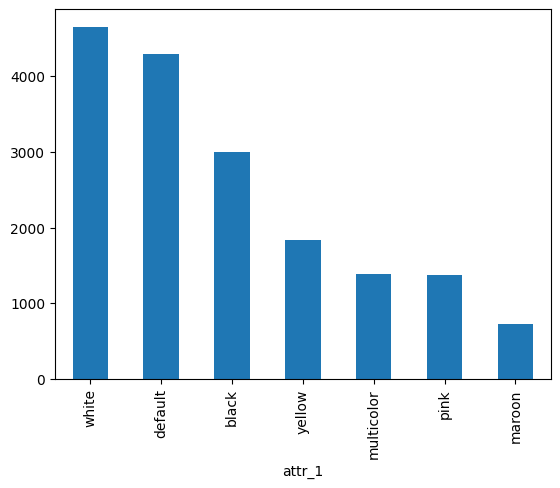

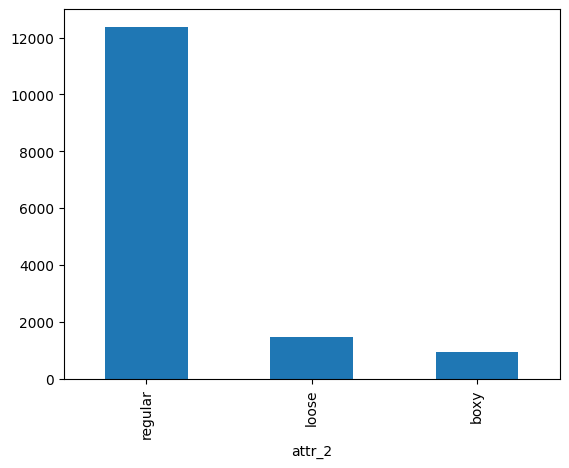

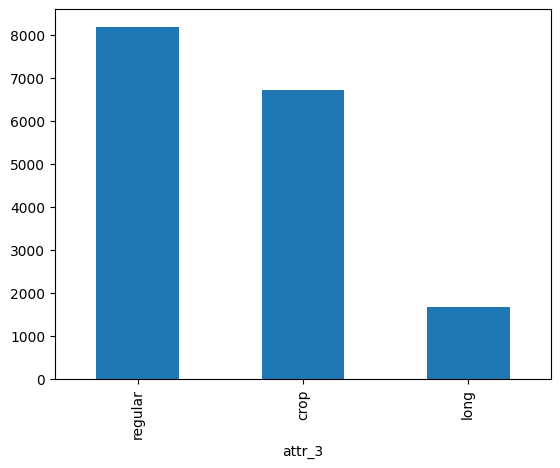

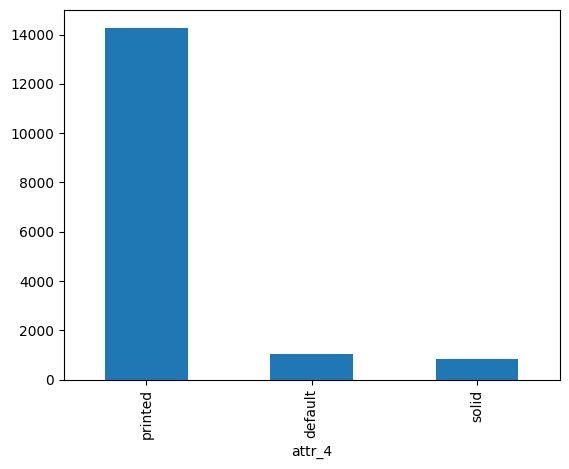

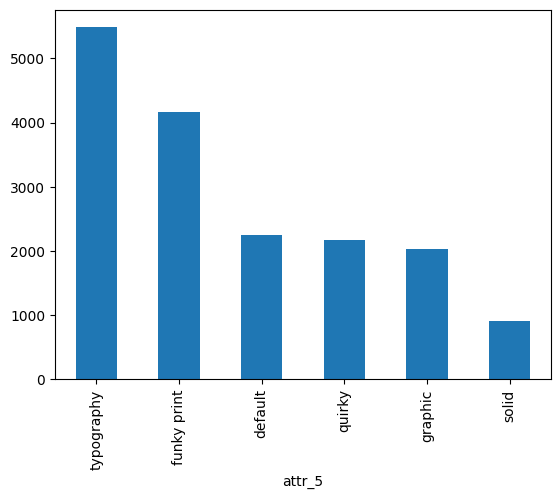

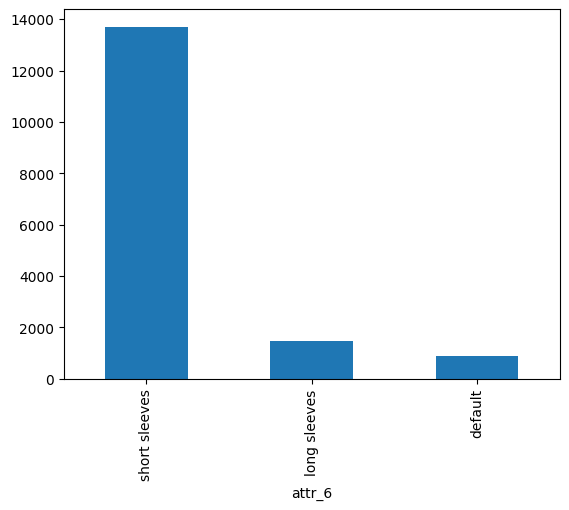

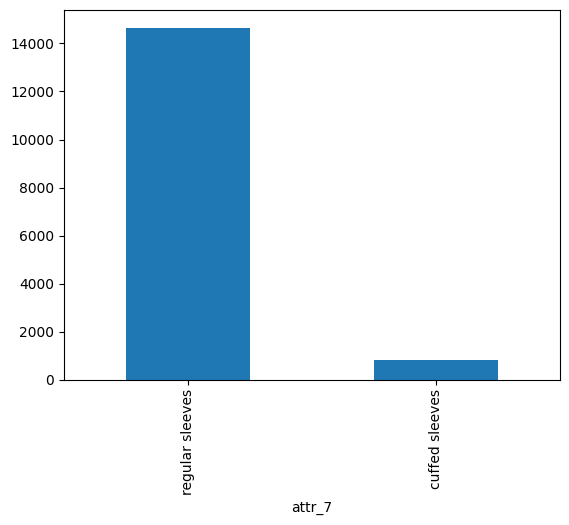

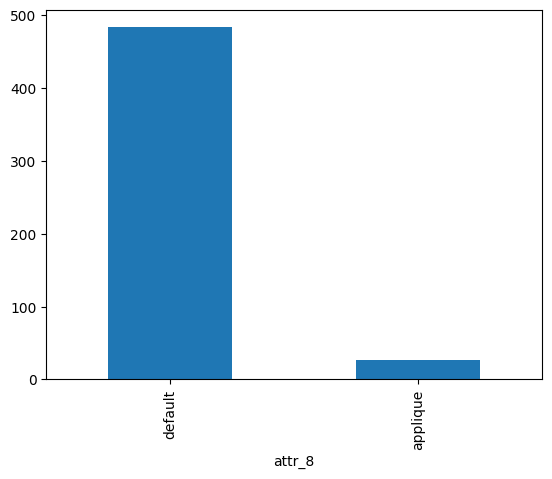

In [16]:
for i in women_tshirts.columns:
  if (i!='id') and (i!='Category'):
    women_tshirts[i].value_counts().plot(kind='bar')
    plt.show()

In [17]:
women_tshirts['attr_1'].fillna('white',inplace=True)
women_tshirts['attr_2'].fillna('regular',inplace=True)
women_tshirts['attr_3'].fillna('regular',inplace=True)
women_tshirts['attr_4'].fillna('printed',inplace=True)
women_tshirts['attr_5'].fillna('typography',inplace=True)
women_tshirts['attr_6'].fillna('short sleeves',inplace=True)
women_tshirts['attr_7'].fillna('regular sleeves',inplace=True)
women_tshirts['attr_8'].fillna('default',inplace=True)

/tmp/ipykernel_30/3096901455.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  women_tshirts['attr_1'].fillna('white',inplace=True)
/tmp/ipykernel_30/3096901455.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [18]:
X4 = women_tshirts.iloc[:,0:2]
y4 = women_tshirts.iloc[:,2:]

In [19]:
y4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18774 entries, 0 to 18773
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   attr_1  18774 non-null  object
 1   attr_2  18774 non-null  object
 2   attr_3  18774 non-null  object
 3   attr_4  18774 non-null  object
 4   attr_5  18774 non-null  object
 5   attr_6  18774 non-null  object
 6   attr_7  18774 non-null  object
 7   attr_8  18774 non-null  object
dtypes: object(8)
memory usage: 1.1+ MB


In [20]:
for i in y4.columns:
  print(i,y4[i].unique(),len(y4[i].unique()))

attr_1 ['multicolor' 'yellow' 'black' 'default' 'pink' 'maroon' 'white'] 7
attr_2 ['loose' 'boxy' 'regular'] 3
attr_3 ['long' 'crop' 'regular'] 3
attr_4 ['default' 'solid' 'printed'] 3
attr_5 ['default' 'quirky' 'solid' 'graphic' 'funky print' 'typography'] 6
attr_6 ['default' 'long sleeves' 'short sleeves'] 3
attr_7 ['regular sleeves' 'cuffed sleeves'] 2
attr_8 ['default' 'applique'] 2


In [21]:
from sklearn.preprocessing import OrdinalEncoder

# Correct the order of categories in the first column and add missing categories for others
oe = OrdinalEncoder(categories=[
    ['multicolor', 'yellow', 'black', 'default', 'pink', 'maroon', 'white'],
    ['loose', 'boxy', 'regular'],
    ['long', 'crop', 'regular'],
    ['default', 'solid', 'printed'],
    ['default', 'quirky', 'solid', 'graphic', 'funky print', 'typography'],
    ['default', 'long sleeves', 'short sleeves'],
    ['regular sleeves', 'cuffed sleeves'],
    ['default', 'applique']
])

y4 = oe.fit_transform(y4)


In [22]:
type(y4)

numpy.ndarray

In [23]:
from sklearn.model_selection import train_test_split
# Load images based on ID in the DataFrame
image_dir = '/kaggle/working/train_images'  # Adjust this path as necessary
max_digits = 6
#image_paths = [os.path.join(image_dir, f"{i}.jpg") for i in X['id']]
image_paths = [os.path.join(image_dir, f'{i:0{max_digits}}.jpg') for i in range(32601,51375)]
# Check if all images are accessible
for path in image_paths:
    if not os.path.exists(path):
        print(f"Missing image: {path}")


def load_and_preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, [128, 128])
        img = img / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)


In [24]:
X4 = load_and_preprocess_images(image_paths)

In [25]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

input_shape = (128, 128, 3)

input_layer = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

#7 3 3 3 6 3 3 3
# Define output layers for 8 attributes
output_attr1 = Dense(7, activation='softmax', name='attr1_output')(x)
output_attr2 = Dense(3, activation='softmax', name='attr2_output')(x)
output_attr3 = Dense(3, activation='softmax', name='attr3_output')(x)
output_attr4 = Dense(3, activation='softmax', name='attr4_output')(x)
output_attr5 = Dense(6, activation='softmax', name='attr5_output')(x)
output_attr6 = Dense(3, activation='softmax', name='attr6_output')(x)
output_attr7 = Dense(2, activation='softmax', name='attr7_output')(x)
output_attr8 = Dense(2, activation='softmax', name='attr8_output')(x)

# Create model with 8 outputs
women_tshirts = Model(inputs=input_layer, outputs=[
    output_attr1, output_attr2, output_attr3,
    output_attr4, output_attr5, output_attr6,
    output_attr7, output_attr8
])

opt = Adam(0.0002)
women_tshirts.compile(optimizer=opt,
              loss={
                  'attr1_output': 'sparse_categorical_crossentropy',
                  'attr2_output': 'sparse_categorical_crossentropy',
                  'attr3_output': 'sparse_categorical_crossentropy',
                  'attr4_output': 'sparse_categorical_crossentropy',
                  'attr5_output': 'sparse_categorical_crossentropy',
                  'attr6_output': 'sparse_categorical_crossentropy',
                  'attr7_output': 'sparse_categorical_crossentropy',
                  'attr8_output': 'sparse_categorical_crossentropy'
              },
              metrics={
                  'attr1_output': 'accuracy',
                  'attr2_output': 'accuracy',
                  'attr3_output': 'accuracy',
                  'attr4_output': 'accuracy',
                  'attr5_output': 'accuracy',
                  'attr6_output': 'accuracy',
                  'attr7_output': 'accuracy',
                  'attr8_output': 'accuracy'
              })

women_tshirts.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │        128 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 63, 63,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 61, 61,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 59, 59,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 59, 59,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 59, 59,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 445568)    │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 57,032,832 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dropout_3[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attr1_output        │ (None, 7)         │        903 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attr2_output        │ (None, 3)         │        387 │ batch_normalizat… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attr3_output        │ (None, 3)         │        387 │ batch_normalizat

 Total params: 57,131,229 (217.94 MB)

 Trainable params: 57,130,525 (217.94 MB)

 Non-trainable params: 704 (2.75 KB)

In [26]:
X4.shape,y4.shape

((18774, 128, 128, 3), (18774, 8))

In [27]:
X4_filtered = X4
y4_filtered = y4
X4_train, X4_val, y4_train, y4_val = train_test_split(
    X4_filtered, y4_filtered, test_size=0.2, random_state=42
)


In [28]:
y4_train_attr1 = y4_train[:, 0]
y4_train_attr2 = y4_train[:, 1]
y4_train_attr3 = y4_train[:, 2]
y4_train_attr4 = y4_train[:, 3]
y4_train_attr5 = y4_train[:, 4]
y4_train_attr6 = y4_train[:, 5]
y4_train_attr7 = y4_train[:, 6]
y4_train_attr8 = y4_train[:, 7]


In [29]:
y4_val_attr1 = y4_val[:, 0]
y4_val_attr2 = y4_val[:, 1]
y4_val_attr3 = y4_val[:, 2]
y4_val_attr4 = y4_val[:, 3]
y4_val_attr5 = y4_val[:, 4]
y4_val_attr6 = y4_val[:, 5]
y4_val_attr7 = y4_val[:, 6]
y4_val_attr8 = y4_val[:, 7]


In [32]:
batch_size = 64
epochs = 10
women_tshirts.fit(X4_train,
          [y4_train_attr1, y4_train_attr2, y4_train_attr3, y4_train_attr4, y4_train_attr5, y4_train_attr6, y4_train_attr7, y4_train_attr8],
          validation_data=(X4_val,
                           [y4_val_attr1, y4_val_attr2, y4_val_attr3, y4_val_attr4, y4_val_attr5, y4_val_attr6, y4_val_attr7, y4_val_attr8]),
          batch_size=batch_size,
          epochs=epochs)


Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - attr1_output_accuracy: 0.8610 - attr2_output_accuracy: 0.9177 - attr3_output_accuracy: 0.8718 - attr4_output_accuracy: 0.9625 - attr5_output_accuracy: 0.7673 - attr6_output_accuracy: 0.9443 - attr7_output_accuracy: 0.9791 - attr8_output_accuracy: 0.9958 - loss: 2.0087 - val_attr1_output_accuracy: 0.7955 - val_attr2_output_accuracy: 0.9071 - val_attr3_output_accuracy: 0.8088 - val_attr4_output_accuracy: 0.9411 - val_attr5_output_accuracy: 0.6357 - val_attr6_output_accuracy: 0.9310 - val_attr7_output_accuracy: 0.9638 - val_attr8_output_accuracy: 0.9987 - val_loss: 3.0042
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - attr1_output_accuracy: 0.8673 - attr2_output_accuracy: 0.9245 - attr3_output_accuracy: 0.8771 - attr4_output_accuracy: 0.9626 - attr5_output_accuracy: 0.7657 - attr6_output_accuracy: 0.9468 - attr7_output_accuracy: 0.9767 - attr8_output_accuracy: 0.9942 - loss: 1.9609 - val_attr1_output_accuracy: 0.7590 - val_a

In [31]:
women_tshirts.save('women_tshirts_weights.keras')

In [33]:
from sklearn.preprocessing import LabelEncoder

# Assuming these are the LabelEncoders used during encoding
attr1_encoder = LabelEncoder()
attr2_encoder = LabelEncoder()
attr3_encoder = LabelEncoder()
attr4_encoder = LabelEncoder()
attr5_encoder = LabelEncoder()
attr6_encoder = LabelEncoder()
attr7_encoder = LabelEncoder()
attr8_encoder = LabelEncoder()
  
# Fit the encoders with the classes if not already done (replace with actual classes)
attr1_encoder.fit(y4_train_attr1)
attr2_encoder.fit(y4_train_attr2)
attr3_encoder.fit(y4_train_attr3)
attr4_encoder.fit(y4_train_attr4)
attr5_encoder.fit(y4_train_attr5)
attr6_encoder.fit(y4_train_attr6)
attr7_encoder.fit(y4_train_attr7)
attr8_encoder.fit(y4_train_attr8)
  
predictions = []

# Get model predictions for all attributes
pred_attr1, pred_attr2, pred_attr3, pred_attr4, pred_attr5,pred_attr6,pred_attr7,pred_attr8 = women_tshirts.predict(X4_val)

# Iterate over each sample and decode predictions
for i in range(len(X4_val)):
    predicted_attr1_label = attr1_encoder.inverse_transform([np.argmax(pred_attr1[i], axis=0)])[0]
    predicted_attr2_label = attr2_encoder.inverse_transform([np.argmax(pred_attr2[i], axis=0)])[0]
    predicted_attr3_label = attr3_encoder.inverse_transform([np.argmax(pred_attr3[i], axis=0)])[0]
    predicted_attr4_label = attr4_encoder.inverse_transform([np.argmax(pred_attr4[i], axis=0)])[0]
    predicted_attr5_label = attr5_encoder.inverse_transform([np.argmax(pred_attr5[i], axis=0)])[0]
    predicted_attr6_label = attr6_encoder.inverse_transform([np.argmax(pred_attr6[i], axis=0)])[0]
    predicted_attr7_label = attr7_encoder.inverse_transform([np.argmax(pred_attr7[i], axis=0)])[0]
    predicted_attr8_label = attr8_encoder.inverse_transform([np.argmax(pred_attr8[i], axis=0)])[0]
        

    predictions.append((
        predicted_attr1_label,
        predicted_attr2_label,
        predicted_attr3_label,
        predicted_attr4_label,
        predicted_attr5_label,
        predicted_attr6_label,
        predicted_attr7_label,
        predicted_attr8_label
      ))

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=[
    "Attribute 1", "Attribute 2", "Attribute 3", "Attribute 4", "Attribute 5","Attribute 6","Attribute 7","Attribute 8"
])

# Preview the DataFrame
print(predictions_df.head())



118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step
   Attribute 1  Attribute 2  Attribute 3  Attribute 4  Attribute 5  \
0          3.0          2.0          1.0          2.0          1.0   
1          1.0          2.0          2.0          2.0          5.0   
2          6.0          2.0          2.0          2.0          5.0   
3          1.0          2.0          2.0          0.0          0.0   
4          6.0          2.0          1.0          2.0          5.0   

   Attribute 6  Attribute 7  Attribute 8  
0          2.0          0.0          0.0  
1          2.0          0.0          0.0  
2          2.0          0.0          0.0  
3          2.0          0.0          0.0  
4          2.0          0.0          0.0  


In [34]:
from sklearn.metrics import f1_score

# Initialize lists to store attribute-wise scores
micro_f1_scores = []
macro_f1_scores = []

# Iterate through each attribute's ground truth and predictions
for i, (y_true_attr, y_pred_attr) in enumerate(zip(
        [y4_val_attr1, y4_val_attr2, y4_val_attr3, y4_val_attr4, y4_val_attr5,y4_val_attr6,y4_val_attr7,y4_val_attr8],
        [predictions_df["Attribute 1"], 
         predictions_df["Attribute 2"], 
         predictions_df["Attribute 3"], 
         predictions_df["Attribute 4"], 
         predictions_df["Attribute 5"],
         predictions_df["Attribute 6"],
         predictions_df["Attribute 7"],
         predictions_df["Attribute 8"]
          ])):
    
    # Calculate F1-scores for this attribute
    micro_f1 = f1_score(y_true_attr, y_pred_attr, average='micro')
    macro_f1 = f1_score(y_true_attr, y_pred_attr, average='macro')
    
    # Store the results
    micro_f1_scores.append(micro_f1)
    macro_f1_scores.append(macro_f1)


# Print overall summary
print("\nSummary of Attribute-Wise F1-Scores:")
for i in range(len(micro_f1_scores)):
    print(f"Attribute {i + 1}: Micro F1 = {micro_f1_scores[i]:.4f}, Macro F1 = {macro_f1_scores[i]:.4f}")



Summary of Attribute-Wise F1-Scores:
Attribute 1: Micro F1 = 0.7779, Macro F1 = 0.7628
Attribute 2: Micro F1 = 0.9121, Macro F1 = 0.6359
Attribute 3: Micro F1 = 0.8075, Macro F1 = 0.7548
Attribute 4: Micro F1 = 0.9507, Macro F1 = 0.8059
Attribute 5: Micro F1 = 0.6463, Macro F1 = 0.6202
Attribute 6: Micro F1 = 0.9372, Macro F1 = 0.7899
Attribute 7: Micro F1 = 0.9627, Macro F1 = 0.7879
Attribute 8: Micro F1 = 0.9992, Macro F1 = 0.4998


In [ ]:
test = pd.read_csv('/kaggle/working/s3.csv')

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the class labels for each of the 8 new attributes
attr1_classes = ['multicolor', 'yellow', 'black', 'default', 'pink', 'maroon', 'white']
attr2_classes = ['loose', 'boxy', 'regular']
attr3_classes = ['long', 'crop', 'regular']
attr4_classes = ['default', 'solid', 'printed']
attr5_classes = ['default', 'quirky', 'solid', 'graphic', 'funky print', 'typography']
attr6_classes = ['default', 'long sleeves', 'short sleeves']
attr7_classes = ['regular sleeves','cuffed sleeves']
attr8_classes = [ 'default', 'applique']

# Set the directory for test images
test_image_dir = '/kaggle/input/visual-taxonomy/test_images'  # Adjust this path as necessary

# Load test data from CSV
test_csv_path = '/kaggle/input/visual-taxonomy/test.csv'  # Adjust this path as necessary
df = pd.read_csv(test_csv_path)

# Check if the DataFrame contains the expected columns
print(df.head())  # Debugging output

# Get the desired range of entries
df_sample = df[13349:23280]

# Prepare a list to hold the images and predictions
predictions = []

# Loop through the images
for index, row in df_sample.iterrows():
    image_file = f"{int(row['id']):06}.jpg"  # Assuming the CSV has an 'id' column
    image_path = os.path.join(test_image_dir, image_file)

    # Check if the image exists
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        continue

    # Load and preprocess the image
    test_img = cv2.imread(image_path)
    if test_img is None:
        print(f"Failed to load image: {image_path}")
        continue

    # Resize and reshape the image
    test_img_resized = cv2.resize(test_img, (128, 128))
    test_input = test_img_resized.reshape((1, 128, 128, 3)) / 255.0  # Normalize

    # Make predictions for each attribute using the model
    preds = women_tshirts.predict(test_input)  # This assumes women_tshirts is the trained model
    predicted_indices = [np.argmax(pred, axis=1)[0] for pred in preds]

    # Store predictions by mapping indices to class labels
    predictions.append((
        image_file,
        attr1_classes[predicted_indices[0]],
        attr2_classes[predicted_indices[1]],
        attr3_classes[predicted_indices[2]],
        attr4_classes[predicted_indices[3]],
        attr5_classes[predicted_indices[4]],
        attr6_classes[predicted_indices[5]],
        attr7_classes[predicted_indices[6]],
        attr8_classes[predicted_indices[7]]
    ))

    # Update DataFrame with predicted labels
    test.loc[index, 'attr_1'] = attr1_classes[predicted_indices[0]]
    test.loc[index, 'attr_2'] = attr2_classes[predicted_indices[1]]
    test.loc[index, 'attr_3'] = attr3_classes[predicted_indices[2]]
    test.loc[index, 'attr_4'] = attr4_classes[predicted_indices[3]]
    test.loc[index, 'attr_5'] = attr5_classes[predicted_indices[4]]
    test.loc[index, 'attr_6'] = attr6_classes[predicted_indices[5]]
    test.loc[index, 'attr_7'] = attr7_classes[predicted_indices[6]]
    test.loc[index, 'attr_8'] = attr8_classes[predicted_indices[7]]
    test.loc[index, 'len'] = 8

# Convert the predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['id', 'attr_1', 'attr_2', 'attr_3', 'attr_4', 'attr_5', 'attr_6', 'attr_7', 'attr_8'])



In [ ]:
test.to_csv('s4.csv')

-----------------------------------------THE END----------------------------------------------